In [1]:
!git clone https://github.com/ChaoningZhang/MobileSAM.git

Cloning into 'MobileSAM'...
remote: Enumerating objects: 1011, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 1011 (delta 347), reused 261 (delta 260), pack-reused 604 (from 1)
Receiving objects: 100% (1011/1011), 95.44 MiB | 43.15 MiB/s, done.
Resolving deltas: 100% (461/461), done.


In [2]:
import kagglehub
import os, glob, cv2, torch, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch import nn
import tifffile

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
base_path = kagglehub.dataset_download("ipateam/nuinsseg")
def get_image_mask_paths(base_dir):
    img_list, mask_list = [], []
    for organ in os.listdir(base_dir):
        img_dir = os.path.join(base_dir, organ, "tissue images")
        mask_dir = os.path.join(base_dir, organ, "label masks")
        if not os.path.isdir(img_dir) or not os.path.isdir(mask_dir): continue
        imgs = sorted(glob.glob(os.path.join(img_dir, "*.png")))
        masks = sorted(glob.glob(os.path.join(mask_dir, "*.tif")))
        if len(imgs) == len(masks):
            img_list.extend(imgs); mask_list.extend(masks)
    return img_list, mask_list

image_paths, mask_paths = get_image_mask_paths(base_path)
print("Displaying sample image and tiff file pair for reference......")
print(image_paths[:1])
print(mask_paths[:1])
print(f" The final Total pairs: {len(image_paths)}")

Displaying sample image and tiff file pair for reference......
['/kaggle/input/mouse muscle_tibia/tissue images/mouse_muscle_tibia_01.png']
['/kaggle/input/mouse muscle_tibia/label masks/mouse_muscle_tibia_01.tif']
 The final Total pairs: 665


displaying the Image and Mask......


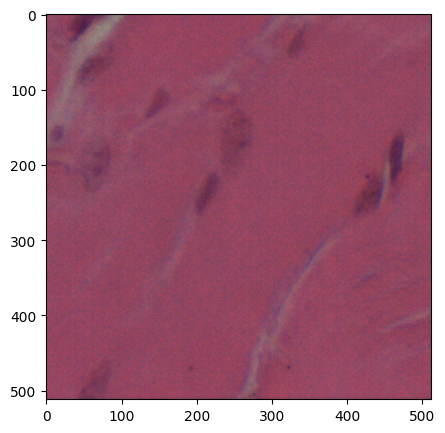

(512, 512)
[ 0  1  2  3  4  5  6  7  8  9 10 11]
uint16


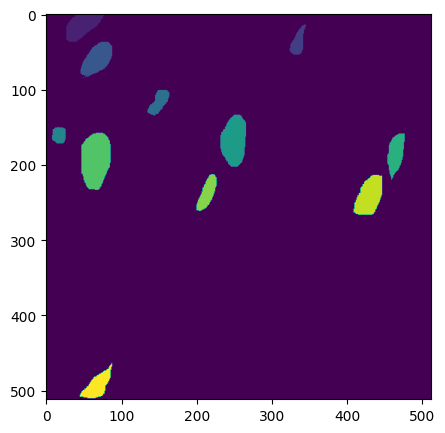

In [4]:
print("displaying the Image and Mask......")

img = cv2.imread(image_paths[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

mask = tifffile.imread(mask_paths[4])
print(mask.shape)
print(np.unique(mask))
print(mask.dtype)
plt.figure(figsize=(5,5))
plt.imshow(mask)
plt.show()

In [5]:
class NuInsSegDatasetFunction(Dataset):
    def __init__(self, imgs, masks, size=1024):
        self.imgs, self.masks = imgs, masks
        self.size = size

    def __len__(self): return len(self.imgs)

    def __getitem__(self, idx):
        img = cv2.imread(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.size, self.size))
        img = torch.tensor(img / 255.0).permute(2,0,1).float()

        mask = tifffile.imread(self.masks[idx])
        if mask is None:
            print(f"Error reading mask at index {idx}: {self.masks[idx]}")
            return None

        #mask = (mask, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.size, self.size))
        mask = torch.tensor((mask > 0).astype(np.float32)).unsqueeze(0)

        return img, mask


dataset = NuInsSegDatasetFunction(image_paths, mask_paths)

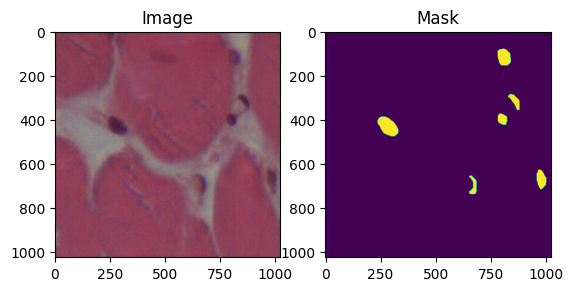

In [6]:
sample_img, sample_mask = dataset[10]
plt.subplot(1, 2, 1); plt.imshow(sample_img.permute(1,2,0)); plt.title("Image")
plt.subplot(1, 2, 2); plt.imshow(sample_mask.squeeze()); plt.title("Mask")
plt.show()

In [7]:
class LoRALinearFunction(nn.Module):
    def __init__(self, orig, r=4, alpha=1.0):
        super().__init__()
        self.weight = orig.weight; self.bias = orig.bias
        self.r = r; self.alpha = alpha
        self.A = nn.Parameter(torch.randn(r, orig.in_features) * 0.01)
        self.B = nn.Parameter(torch.randn(orig.out_features, r) * 0.01)
        self.scaling = alpha / r
        self.weight.requires_grad = False
        if self.bias is not None: self.bias.requires_grad = False

    def forward(self, x):
        base = x @ self.weight.T
        if self.bias is not None: base += self.bias
        lora = (x @ self.A.T) @ self.B.T
        return base + self.scaling * lora

In [8]:
import sys
sys.path.append("./MobileSAM")
from MobileSAM.mobile_sam.build_sam import sam_model_registry

checkPath = "/kaggle/working/MobileSAM/weights/mobile_sam.pt"
sam = sam_model_registry["vit_t"](checkpoint=checkPath).to(device)
for p in sam.parameters(): p.requires_grad = False

def apply_lora_fun(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear):
            setattr(module, name, LoRALinearFunction(child).to(device))
        else: apply_lora_fun(child)

apply_lora_fun(sam.image_encoder)
for p in sam.mask_decoder.parameters(): p.requires_grad = True

optimizer = torch.optim.Adam([p for p in sam.parameters() if p.requires_grad], lr=1e-4)
print("loaded MobileSAM weight successfully....")

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/kaggle/working/MobileSAM/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with MobileSAM.mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/kaggle/working/MobileSAM/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry w

loaded MobileSAM weight successfully....


In [9]:
# Count and report parameters
total_params = sum(p.numel() for p in sam.parameters())
trainable_params = sum(p.numel() for p in sam.parameters() if p.requires_grad)

print(f"Total Parameters        : {total_params:,}")
print(f"Trainable Parameters    : {trainable_params:,}")
print(f"Percentage Tunable      : {100 * trainable_params / total_params:.4f}%")


Total Parameters        : 10,254,156
Trainable Parameters    : 4,182,404
Percentage Tunable      : 40.7874%


In [9]:
## Defining Dice coefficient mehtod
def Dice_Coefficient(predd, target, smooth=1e-6):
    predd = predd.contiguous().view(-1)
    target = target.contiguous().view(-1)
    inter = (predd * target).sum()
    return (2 * inter + smooth) / (predd.sum() + target.sum() + smooth)

In [10]:
## Defining AJI Score method 
def Aji_Score(gt, pred):
    from skimage.measure import label, regionprops
    gt = label(gt)
    pred = label(pred)
    used = set()
    inter_sum = 0
    union_sum = 0

    for g in regionprops(gt):
        best_iou, best_p = 0, None
        for p in regionprops(pred):
            if p.label in used:
                continue
            gi = (gt == g.label)
            pi = (pred == p.label)
            inter = np.logical_and(gi, pi).sum()
            union = np.logical_or(gi, pi).sum()
            iou = inter / (union + 1e-6)
            if iou > best_iou:
                best_iou = iou
                best_p = p.label
        if best_p is not None:
            used.add(best_p)
            gi = (gt == g.label)
            pi = (pred == best_p)
            inter_sum += np.logical_and(gi, pi).sum()
            union_sum += np.logical_or(gi, pi).sum()

    for p in regionprops(pred):
        if p.label not in used:
            union_sum += (pred == p.label).sum()

    return inter_sum / (union_sum + 1e-6)


In [11]:
##  Compute PQ, SQ, and DQ for pairwise instance segmentation evaluation.

    # Args:
    #     true (np.ndarray): Ground truth segmentation (instance labels).
    #     pred (np.ndarray): Predicted segmentation (instance labels).
    #     match_iou (float): IoU threshold for pairing ground truth and prediction instances.

    # Returns:
    #     [dq, sq, pq]: Measurement statistics: DQ, SQ, and PQ.
    #     [paired_true, paired_pred, unpaired_true, unpaired_pred]: Pairing information.
    # 
   

def Fast_PQ(true, pred, match_iou=0.5):
    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list_item = list(np.unique(true))
    pred_id_list_item = list(np.unique(pred))
    
    # This condition Return early if only background is present
    if len(pred_id_list_item) == 1:
        return [0, 0, 0], [0, 0, 0, 0]

    # This generate masks for each true and predicted instance
    true_masks = [None]  # here the background is ignored
    for t in true_id_list_item[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [None]  # here the background is ignored
    for p in pred_id_list_item[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # Pairwise IoU matrix which initialize with zeros
    pairwise_iou_matrix = np.zeros([len(true_id_list_item) - 1, len(pred_id_list_item) - 1], dtype=np.float64)

    # Compute pairwise IoU
    for true_id in true_id_list_item[1:]:  # skip background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore background
                continue
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou_matrix[true_id - 1, pred_id - 1] = iou

    # Handle IoU thresholding for pairing
    if match_iou >= 0.5:
        paired_iou = pairwise_iou_matrix[pairwise_iou_matrix > match_iou]
        pairwise_iou_matrix[pairwise_iou_matrix <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou_matrix)
        paired_iou = pairwise_iou_matrix[paired_true, paired_pred]
        paired_true += 1  # Adjusting for instance IDs (zero-based to 1-based)
        paired_pred += 1
    else:
        # Use Munkres (Hungarian algorithm) for optimal unique pairing
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou_matrix)
        paired_iou = pairwise_iou_matrix[paired_true, paired_pred]
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # Find unpaired instances
    unpaired_true = [idx for idx in true_id_list_item[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list_item[1:] if idx not in paired_pred]

    # This get stored and Compute TP, FP, FN, DQ, SQ
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)

    dq = tp / (tp + 0.5 * fp + 0.5 * fn)  # DQ
    sq = paired_iou.sum() / (tp + 1e-6)  # SQ
    pq = dq * sq  # PQ

    return [dq, sq, pq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


In [12]:
# from sklearn.model_selection import KFold


kf_fold = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf_fold.split(dataset))

all_dice, all_aji, all_pq = [], [], []

for fold, (train_idx, test_idx) in enumerate(folds):
    print(f"\nRunning Fold ---> {fold+1}/5")

    train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=16, shuffle=True)
    test_loader  = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=8)

    for epoch in range(10):  
        sam.train(); total_loss = 0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            imgs, masks = imgs.to(device), masks.to(device)

            with torch.no_grad():
                emb = sam.image_encoder(imgs)
            sparse, dense = sam.prompt_encoder(None, None, None)
            image_pe = sam.prompt_encoder.get_dense_pe()

            masks_pred, _ = sam.mask_decoder(emb, image_pe, sparse, dense, False)
            logits = masks_pred[:, 0]  # [B, H, W]
            logits = nn.functional.interpolate(logits.unsqueeze(1), size=(1024, 1024), mode='bilinear', align_corners=False)

            loss = nn.functional.binary_cross_entropy_with_logits(logits, masks)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item()

        print(f"|| Epoch {epoch+1} Loss || {total_loss / len(train_loader):.4f}")

    # # Evaluaing on test set
    # sam.eval(); dice_scores, aji_scores, pq_scores = [], [], []
    # with torch.no_grad():
    #     for imgs, masks in tqdm(test_loader, desc="Evaluating"):
    #         imgs, masks = imgs.to(device), masks.to(device)
    #         emb = sam.image_encoder(imgs)
    #         sparse, dense = sam.prompt_encoder(None, None, None)
    #         image_pe = sam.prompt_encoder.get_dense_pe()
    #         masks_pred, _ = sam.mask_decoder(emb, image_pe, sparse, dense, False)
    #         pred = torch.sigmoid(masks_pred[:, 0])  # [B, H, W]
    #         pred = nn.functional.interpolate(pred.unsqueeze(1), size=(1024, 1024), mode='bilinear', align_corners=False)

    #         pred_bin = (pred > 0.3).float().cpu().numpy().squeeze().astype(np.uint8)
    #         gt_bin = masks.cpu().numpy().squeeze().astype(np.uint8)
    #         #print("Num GT labels:", np.unique(gt_bin, return_counts=True))
    #         #print("Num Pred labels:", np.unique(pred_bin, return_counts=True))

    #         dice_scores.append(Dice_Coefficient(torch.tensor(pred_bin), torch.tensor(gt_bin)).item())
    #         # Not Required using next line
    #         # aji_scores.append(fast_aji(gt_bin, pred_bin))
    #         aji_scores.append(Aji_Score(gt_bin, pred_bin))
    #         pq_result, _ = Fast_PQ(gt_bin, pred_bin)
    #         pq_scores.append(pq_result[2])

    # print(f" ****************Fold Dice: {np.mean(dice_scores):.4f} | AJI: {np.mean(aji_scores):.4f} | PQ: {np.mean(pq_scores):.4f} *************")
    # all_dice.append(np.mean(dice_scores))
    # all_aji.append(np.mean(aji_scores))
    # all_pq.append(np.mean(pq_scores))

    # Evaluaing on test set (optimized for speed)
    sam.eval()
    dice_scores, aji_scores, pq_scores = [], [], []

    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device)
            masks = masks.to(device)
    
            # Forward pass
            emb = sam.image_encoder(imgs)
            sparse, dense = sam.prompt_encoder(None, None, None)
            image_pe = sam.prompt_encoder.get_dense_pe()
            masks_pred, _ = sam.mask_decoder(emb, image_pe, sparse, dense, False)
    
            # Loop over each item in batch for evaluation metrics
            for i in range(imgs.size(0)):
                pred = torch.sigmoid(masks_pred[i, 0]).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
                pred = nn.functional.interpolate(pred, size=(1024, 1024), mode='bilinear', align_corners=False)
                pred_bin = (pred > 0.3).float().cpu().numpy().squeeze().astype(np.uint8)
    
                gt_bin = nn.functional.interpolate(masks[i].unsqueeze(0), size=(1024, 1024), mode='nearest')
                gt_bin = gt_bin.cpu().numpy().squeeze().astype(np.uint8)
    
                dice = Dice_Coefficient(torch.tensor(pred_bin), torch.tensor(gt_bin)).item()
                aji = Aji_Score(gt_bin, pred_bin)
                pq_result, _ = Fast_PQ(gt_bin, pred_bin)
    
                dice_scores.append(dice)
                aji_scores.append(aji)
                pq_scores.append(pq_result[2])

    print(f" ****************Fold Dice: {np.mean(dice_scores):.4f} | AJI: {np.mean(aji_scores):.4f} | PQ: {np.mean(pq_scores):.4f} *************")
    all_dice.append(np.mean(dice_scores))
    all_aji.append(np.mean(aji_scores))
    all_pq.append(np.mean(pq_scores))


# Final Results
print("\n 5-Fold Average Scores")
print("************************")
print(f"Average Dice Score Result: {np.mean(all_dice):.4f}")
print(f"Average AJI Score Result: {np.mean(all_aji):.4f}")


Running Fold ---> 1/5


Epoch 1: 100%|██████████| 34/34 [01:00<00:00,  1.77s/it]


|| Epoch 1 Loss || 0.3494


Epoch 2: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]


|| Epoch 2 Loss || 0.2529


Epoch 3: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]


|| Epoch 3 Loss || 0.2377


Epoch 4: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]


|| Epoch 4 Loss || 0.2225


Epoch 5: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]


|| Epoch 5 Loss || 0.2183


Epoch 6: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]


|| Epoch 6 Loss || 0.2098


Epoch 7: 100%|██████████| 34/34 [00:52<00:00,  1.55s/it]


|| Epoch 7 Loss || 0.2125


Epoch 8: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]


|| Epoch 8 Loss || 0.2036


Epoch 9: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]


|| Epoch 9 Loss || 0.2000


Epoch 10: 100%|██████████| 34/34 [00:53<00:00,  1.58s/it]


|| Epoch 10 Loss || 0.2052


Evaluating: 100%|██████████| 17/17 [20:11<00:00, 71.27s/it]


 ****************Fold Dice: 0.5873 | AJI: 0.2965 | PQ: 0.2729 *************

Running Fold ---> 2/5


Epoch 1: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]


|| Epoch 1 Loss || 0.2282


Epoch 2: 100%|██████████| 34/34 [00:50<00:00,  1.47s/it]


|| Epoch 2 Loss || 0.2113


Epoch 3: 100%|██████████| 34/34 [00:49<00:00,  1.47s/it]


|| Epoch 3 Loss || 0.2130


Epoch 4: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it]


|| Epoch 4 Loss || 0.2077


Epoch 5: 100%|██████████| 34/34 [00:49<00:00,  1.47s/it]


|| Epoch 5 Loss || 0.2041


Epoch 6: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]


|| Epoch 6 Loss || 0.2057


Epoch 7: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]


|| Epoch 7 Loss || 0.2015


Epoch 8: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]


|| Epoch 8 Loss || 0.2028


Epoch 9: 100%|██████████| 34/34 [00:50<00:00,  1.48s/it]


|| Epoch 9 Loss || 0.2032


Epoch 10: 100%|██████████| 34/34 [00:50<00:00,  1.47s/it]


|| Epoch 10 Loss || 0.2056


Evaluating: 100%|██████████| 17/17 [13:00<00:00, 45.89s/it]


 ****************Fold Dice: 0.6488 | AJI: 0.3983 | PQ: 0.3947 *************

Running Fold ---> 3/5


Epoch 1: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 1 Loss || 0.2033


Epoch 2: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]


|| Epoch 2 Loss || 0.1985


Epoch 3: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]


|| Epoch 3 Loss || 0.2012


Epoch 4: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]


|| Epoch 4 Loss || 0.1996


Epoch 5: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]


|| Epoch 5 Loss || 0.1955


Epoch 6: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 6 Loss || 0.1948


Epoch 7: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 7 Loss || 0.1960


Epoch 8: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]


|| Epoch 8 Loss || 0.1938


Epoch 9: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 9 Loss || 0.1926


Epoch 10: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]


|| Epoch 10 Loss || 0.1925


Evaluating: 100%|██████████| 17/17 [15:27<00:00, 54.56s/it]


 ****************Fold Dice: 0.6716 | AJI: 0.4131 | PQ: 0.4129 *************

Running Fold ---> 4/5


Epoch 1: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]


|| Epoch 1 Loss || 0.1938


Epoch 2: 100%|██████████| 34/34 [00:50<00:00,  1.50s/it]


|| Epoch 2 Loss || 0.1916


Epoch 3: 100%|██████████| 34/34 [00:54<00:00,  1.60s/it]


|| Epoch 3 Loss || 0.1902


Epoch 4: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 4 Loss || 0.1893


Epoch 5: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]


|| Epoch 5 Loss || 0.1893


Epoch 6: 100%|██████████| 34/34 [00:51<00:00,  1.53s/it]


|| Epoch 6 Loss || 0.1872


Epoch 7: 100%|██████████| 34/34 [00:51<00:00,  1.50s/it]


|| Epoch 7 Loss || 0.1851


Epoch 8: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 8 Loss || 0.1865


Epoch 9: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 9 Loss || 0.1820


Epoch 10: 100%|██████████| 34/34 [00:50<00:00,  1.49s/it]


|| Epoch 10 Loss || 0.1835


Evaluating: 100%|██████████| 17/17 [15:30<00:00, 54.74s/it]


 ****************Fold Dice: 0.7141 | AJI: 0.4680 | PQ: 0.4709 *************

Running Fold ---> 5/5


Epoch 1: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]


|| Epoch 1 Loss || 0.1839


Epoch 2: 100%|██████████| 34/34 [00:51<00:00,  1.52s/it]


|| Epoch 2 Loss || 0.1849


Epoch 3: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 3 Loss || 0.1817


Epoch 4: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 4 Loss || 0.1825


Epoch 5: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]


|| Epoch 5 Loss || 0.1811


Epoch 6: 100%|██████████| 34/34 [00:52<00:00,  1.53s/it]


|| Epoch 6 Loss || 0.1834


Epoch 7: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 7 Loss || 0.1846


Epoch 8: 100%|██████████| 34/34 [00:52<00:00,  1.54s/it]


|| Epoch 8 Loss || 0.1799


Epoch 9: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 9 Loss || 0.1783


Epoch 10: 100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


|| Epoch 10 Loss || 0.1771


Evaluating: 100%|██████████| 17/17 [12:45<00:00, 45.03s/it]

 ****************Fold Dice: 0.6837 | AJI: 0.4808 | PQ: 0.4281 *************

 5-Fold Average Scores
************************
Average Dice Score Result: 0.6611
Average AJI Score Result: 0.4114


In [13]:
from skimage.measure import label
from skimage.segmentation import watershed, clear_border
from skimage.morphology import remove_small_objects
from scipy import ndimage as ndi
from skimage.filters import sobel

sam.eval(); dice_scores, aji_scores = [], []

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        emb = sam.image_encoder(imgs)
        sparse, dense = sam.prompt_encoder(None, None, None)
        image_pe = sam.prompt_encoder.get_dense_pe()
        masks_pred, _ = sam.mask_decoder(emb, image_pe, sparse, dense, False)

        # Model prediction
        pred = torch.sigmoid(masks_pred[:, 0])
        pred = nn.functional.interpolate(pred.unsqueeze(1), size=(1024, 1024), mode='bilinear', align_corners=False)
        pred_bin = (pred > 0.3).float().cpu().numpy().squeeze().astype(np.uint8)
        gt_bin = masks.cpu().numpy().squeeze().astype(np.uint8)

        # Post-processing to improve AJI
        distance = ndi.distance_transform_edt(pred_bin)
        edges = sobel(pred_bin)
        markers = label(pred_bin)
        labels = watershed(-distance, markers, mask=pred_bin)

        labels = remove_small_objects(labels, min_size=30)
        labels = clear_border(labels)

        # Recalculate metrics
        dice_scores.append(Dice_Coefficient(torch.tensor(pred_bin), torch.tensor(gt_bin)).item())
        aji_scores.append(Aji_Score(gt_bin, labels))

print(f"The result fro Post-Processed Dice Score: {np.mean(dice_scores):.4f}")
print(f"The Result for Post-Processed AJI : {np.mean(aji_scores):.4f}")


The result fro Post-Processed Dice Score: 0.7147
The Result for Post-Processed AJI : 0.1371


/usr/local/lib/python3.11/dist-packages/skimage/color/colorconv.py:322: RuntimeWarning: divide by zero encountered in divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]


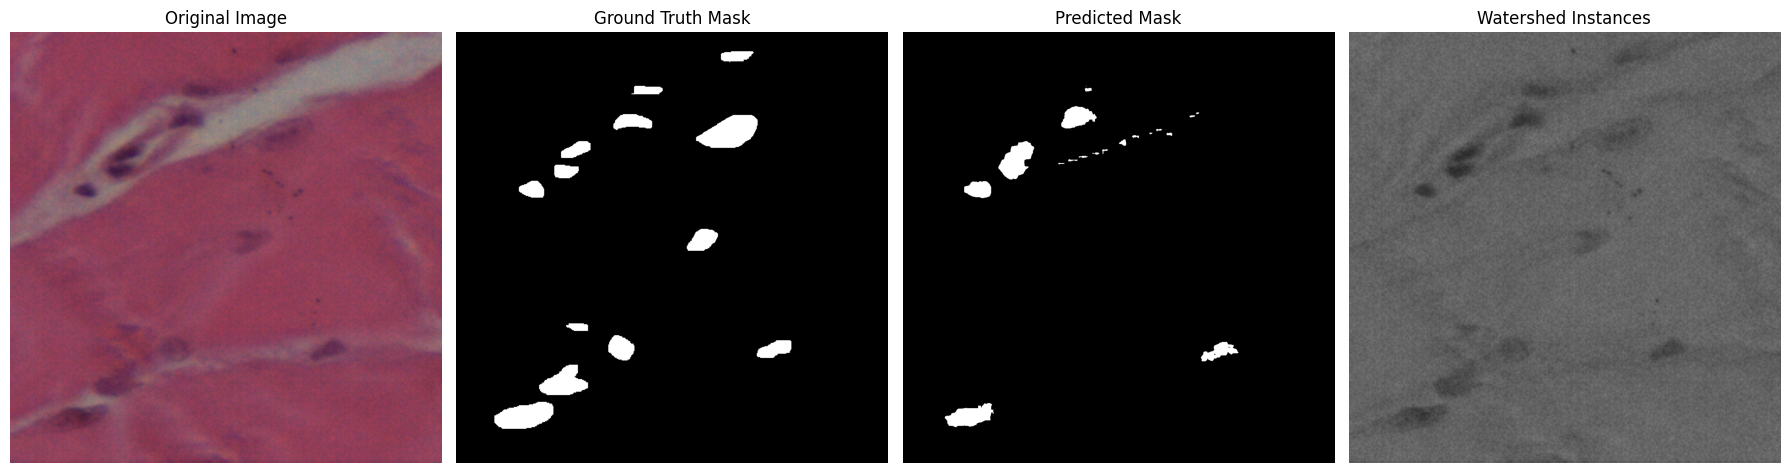

In [14]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb

def visualize_prediction(img_tensor, gt_mask, pred_bin, watershed_labels):
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    gt_mask_np = gt_mask.cpu().squeeze().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    axs[0].imshow(img_np)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(gt_mask_np, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")

    axs[2].imshow(pred_bin[0], cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    axs[3].imshow(label2rgb(watershed_labels[0], image=img_np, bg_label=0))
    axs[3].set_title("Watershed Instances")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()

sam.eval(); dice_scores, aji_scores = [], []

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        emb = sam.image_encoder(imgs)
        sparse, dense = sam.prompt_encoder(None, None, None)
        image_pe = sam.prompt_encoder.get_dense_pe()
        masks_pred, _ = sam.mask_decoder(emb, image_pe, sparse, dense, False)

        pred = torch.sigmoid(masks_pred[:, 0])
        pred = nn.functional.interpolate(pred.unsqueeze(1), size=(1024, 1024), mode='bilinear', align_corners=False)
        pred_bin = (pred > 0.3).float().cpu().numpy().squeeze().astype(np.uint8)
        gt_bin = masks.cpu().numpy().squeeze().astype(np.uint8)

        # Watershed instance splitting
        distance = ndi.distance_transform_edt(pred_bin)
        markers = label(pred_bin)
        labels = watershed(-distance, markers, mask=pred_bin)
        labels = remove_small_objects(labels, min_size=30)
        labels = clear_border(labels)

        # Visualize only first one
        visualize_prediction(imgs[0], masks[0], pred_bin, labels)
        break